In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
plt.rcParams['figure.figsize'] = [15,8] # size of plots in inches

<h3>Модель ДПТ в пространстве состояний</h3>

Входные воздействия: <br> 
*U* - управляющее напряжение <br>
*Mc* – момент сопротивления на валу <br>
Выходные величины: <br>
*i* – ток якоря <br>
*ω* – скорость вращения <br>
Параметры: <br>
*R* - активное сопротивление цепи якоря <br>
*Te* - постоянная якорной цепи <br>
*cF* - произведение конструктивной постоянной на номинальный магнитный поток <br>
*J* - приведенный к валу двигателя момент инерции <br>
*T* - шаг дискретизации

Определение параметров

Параметры для модели со средним значением

In [42]:
R = 0.12
Te = 0.01
cF = 2.35
J = 95
T = 0.01

Для двигателя МП7000-115У4

In [51]:
R = 0.003682;
L = 0.000156;
F = 0.4258; 
J = 172000;
C = 176;
Te = L/R;
cF = C*F;

In [75]:
T = 0.01
sec = 4

Определение модели в простанстве состояний 

In [72]:
A = np.array([[-1/Te, -cF/(R*Te)],
              [cF/J, 0]])
B = np.array([[1/(R*Te), 0],
              [0, -1/J]])
C = np.array([[1, 0],
              [0, 1]])
D = np.array([[0, 0],
              [0, 0]])

Определение начального состояния

In [73]:
x0 = np.array([[0],
               [0]])

In [76]:
u = np.array([[1],
              [0]])

# Define the output signal y
y = np.array([[0],
              [0]])

# Calculate the state transition matrix
Ad = np.eye(A.shape[0]) + A * T

# Calculate the input matrix for the discrete-time system
Bd = B * T

history_x = []
history_y = []

# Iterate over time steps
for t in np.arange(0, sec, T):
    
    # Calculate the next state
    x = np.dot(Ad, x0) + np.dot(Bd, u)
    history_x.append(x)

    # Calculate the output
    y = np.dot(C, x) + np.dot(D, u)
    history_y.append(y)
    
    # Update the initial state
    x0 = x


In [78]:
np.arange(0, sec, T).shape

(400,)

In [79]:
history_x_array = np.array(history_x)
history_y_array = np.array(history_y)

In [80]:
history_x_array.shape, history_y_array.shape

((400, 2, 1), (400, 2, 1))

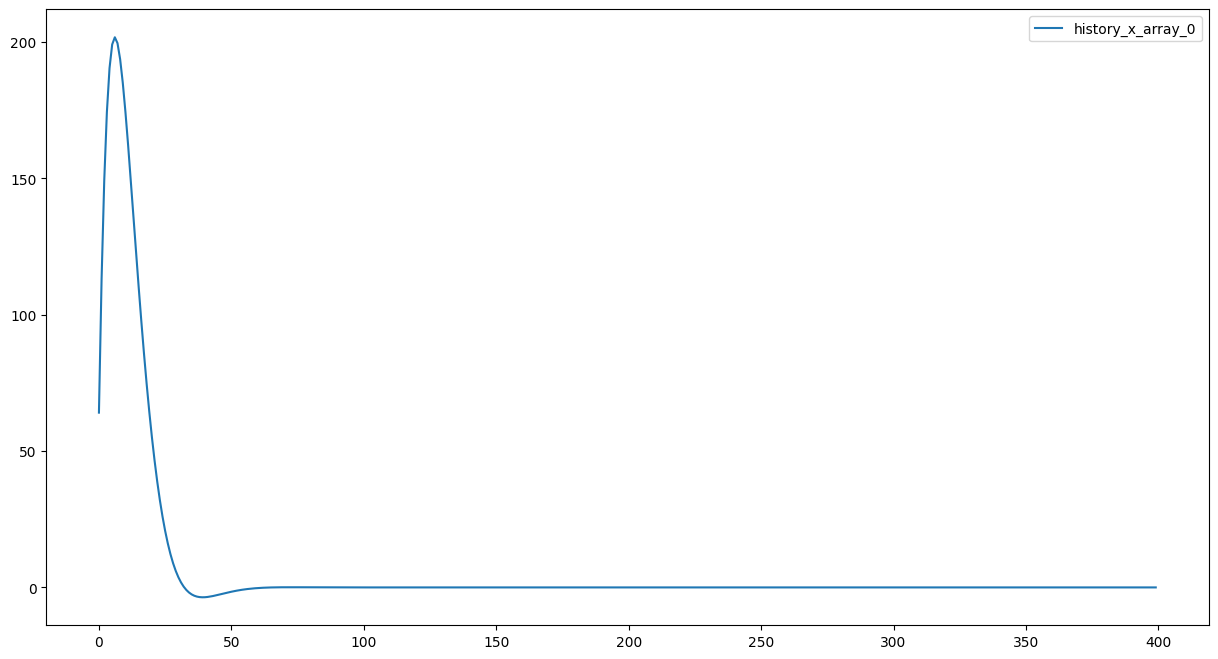

In [81]:
plt.plot(history_x_array[:, 0], label="history_x_array_0")
#plt.plot(history_x_array[:, 1], label="history_x_array_1")
#plt.plot(history_y_array[:, 0], label="history_y_array_0")
#plt.plot(history_y_array[:, 1], label="history_y_array_1")
plt.legend()
plt.show()

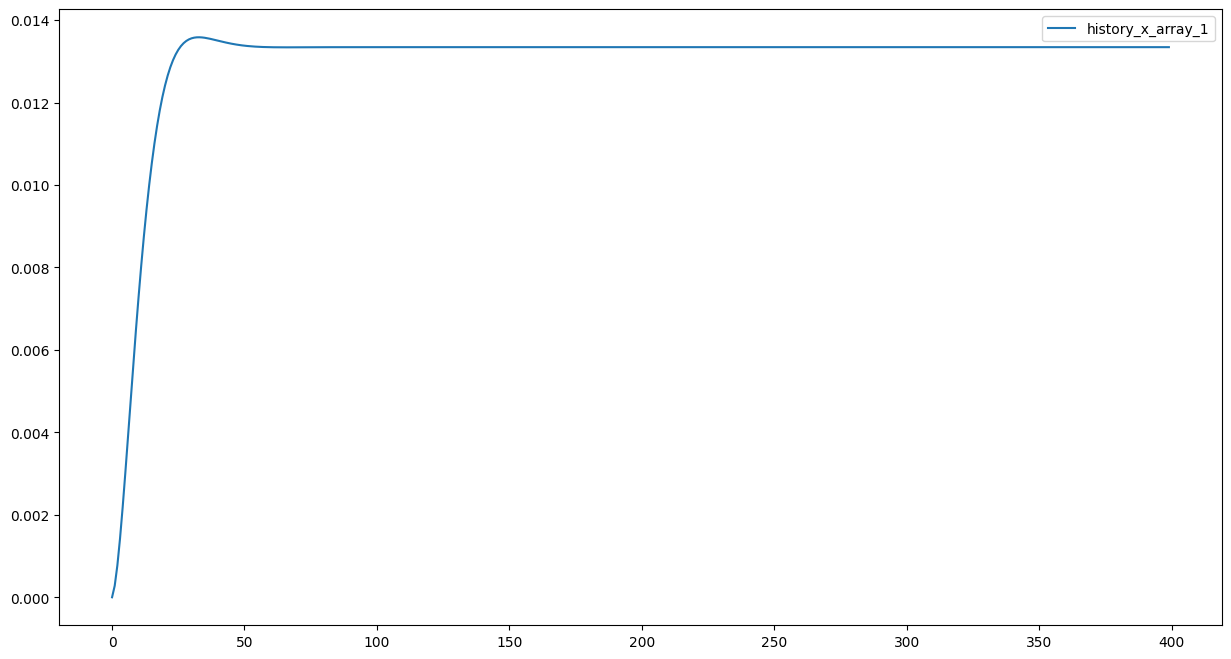

In [82]:
#plt.plot(history_x_array[:, 0], label="history_x_array_0")
plt.plot(history_x_array[:, 1], label="history_x_array_1")
#plt.plot(history_y_array[:, 0], label="history_y_array_0")
#plt.plot(history_y_array[:, 1], label="history_y_array_1")
plt.legend()
plt.show()

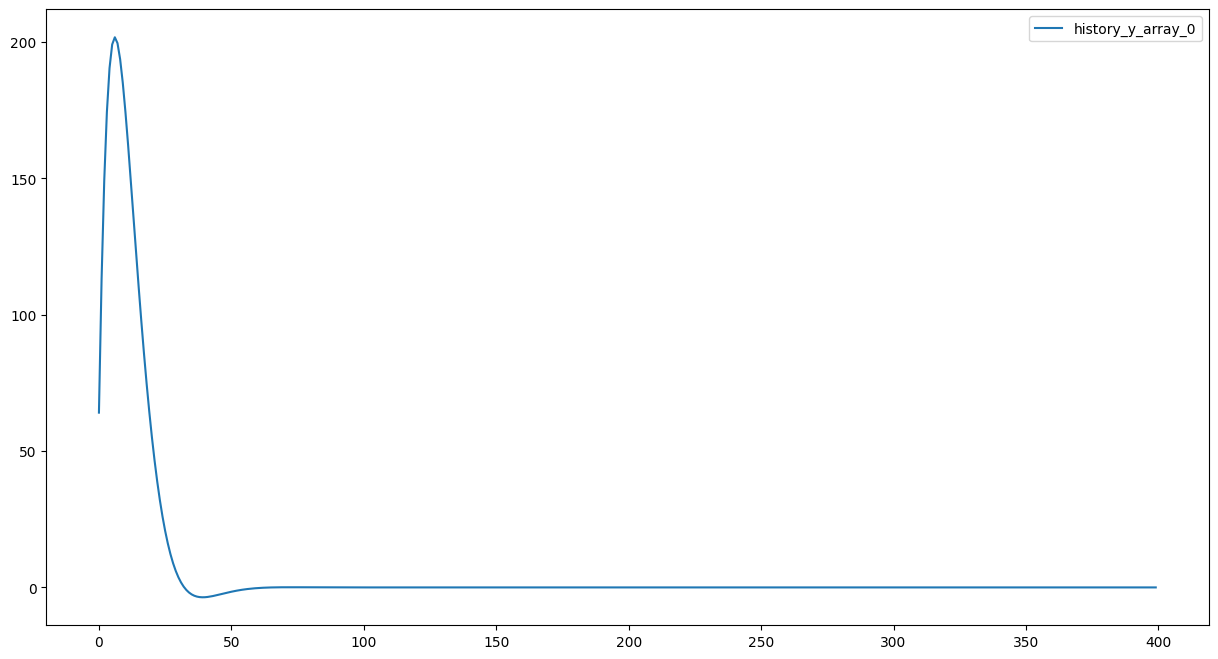

In [83]:
#plt.plot(history_x_array[:, 0], label="history_x_array_0")
#plt.plot(history_x_array[:, 1], label="history_x_array_1")
plt.plot(history_y_array[:, 0], label="history_y_array_0")
#plt.plot(history_y_array[:, 1], label="history_y_array_1")
plt.legend()
plt.show()

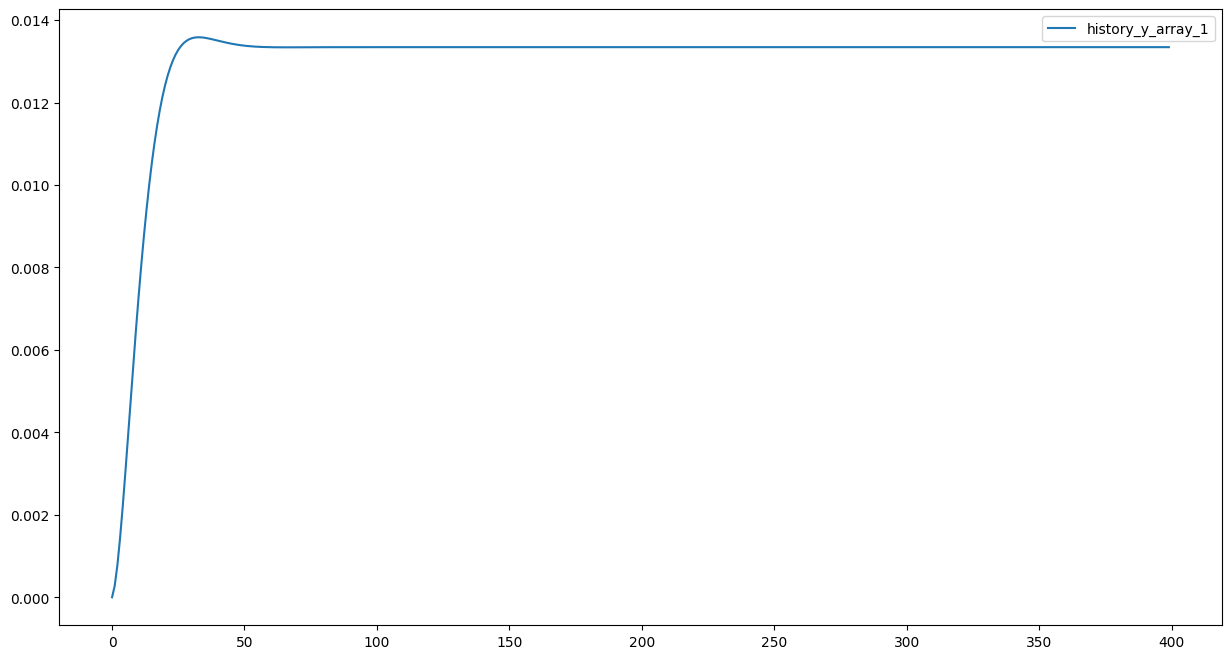

In [84]:
#plt.plot(history_x_array[:, 0], label="history_x_array_0")
#plt.plot(history_x_array[:, 1], label="history_x_array_1")
#plt.plot(history_y_array[:, 0], label="history_y_array_0")
plt.plot(history_y_array[:, 1], label="history_y_array_1")
plt.legend()
plt.show()

<h3>РНС</h3>

Параметры

In [45]:
LW11 = (J*R*Te)/(2*(T*T*cF*cF + J*R*T + J*R*Te)) - T/(2*Te) + 1/2;
LW12 =  - (T*cF)/(2*R*Te) - (J*T*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
LW21 = (T*cF)/(2*J) + (R*T*Te*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
LW22 = (J*R*(T + Te))/(2*(T*T*cF*cF + J*R*T + J*R*Te)) + 1/2;

IW11 = (T*((J*R*Te)/(T*T*cF*cF + J*R*T + J*R*Te) + 1))/(2*R*Te);
IW12 =  (T*T*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
IW21 =  (T*T*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
IW22 = -(T*((J*R*(T + Te))/(T*T*cF*cF + J*R*T + J*R*Te) + 1))/(2*J);

Вычисление параметров ДПТ по весовым коэффициентам сети

In [47]:
J_m = -LW22/IW22*T
cF_m = -2*(1-LW22*IW21/LW12/IW22)*LW21*LW22/IW22
Te_m = T/2/(IW11*LW21*LW22/LW12/IW22 - LW11)
R_m = 2*LW21*LW22*(IW11*LW21*LW22/LW12/IW22 - LW11)/LW12/IW22

Матрица весовых коэфициентов

In [50]:
A = np.array([[LW11, LW12, IW11, IW12],
              [LW21, LW22, IW21, IW22]])